In [194]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from IPython.display import display
from torch.optim.lr_scheduler import StepLR

In [195]:
transform_train = transforms.Compose([
    transforms.Resize((30, 30)),
    transforms.RandomRotation(5),
    transforms.RandomAffine(0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.Resize((30, 30)),
    transforms.ToTensor()
])

train_data = torchvision.datasets.GTSRB(root='./data', split='train', download=True, transform=transform_train)

In [196]:
train_data

Dataset GTSRB
    Number of datapoints: 26640
    Root location: ./data
    StandardTransform
Transform: Compose(
               Resize(size=(30, 30), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=0)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.05, 0.05))
               ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=None, hue=None)
               ToTensor()
           )

In [197]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [198]:
test_data = torchvision.datasets.GTSRB(root='./data', split='test', download=True, transform=transform_test)
test_data

Dataset GTSRB
    Number of datapoints: 12630
    Root location: ./data
    StandardTransform
Transform: Compose(
               Resize(size=(30, 30), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

torch.Size([3, 30, 30])


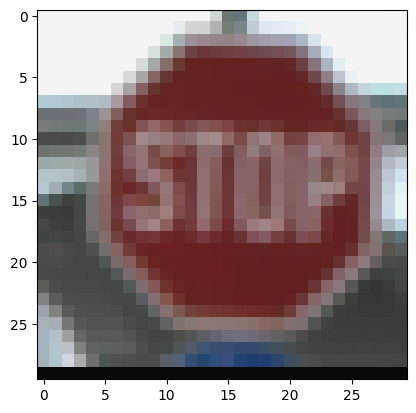

14


In [199]:
img, label = train_data[15200]
print(img.shape)
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(label)

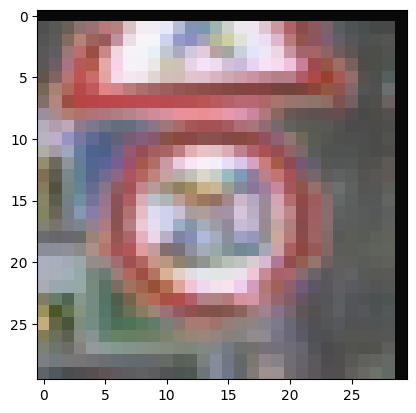

In [200]:
conv = nn.Conv2d(3, 32, 3, 1)
for i, (X_train, y_train) in enumerate(train_data):
  break
plt.imshow(X_train.permute(1, 2, 0))
plt.show()

In [201]:
X_train.shape

torch.Size([3, 30, 30])

In [202]:
x = X_train.unsqueeze(0)
x = F.relu(conv(x))
x.shape

torch.Size([1, 32, 28, 28])

In [203]:
#plt.imshow(x.detach().reshape(30, 30))

In [204]:
x = F.max_pool2d(x, 2, 2)
x.shape

torch.Size([1, 32, 14, 14])

In [205]:
conv = nn.Conv2d(32, 64, 3, 1, 1)
x = F.relu(conv(x))
print(x.shape)
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 64, 14, 14])
torch.Size([1, 64, 7, 7])


In [215]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 128, 3, 1, 1)
    self.bn4 = nn.BatchNorm2d(128)
    self.dropout = nn.Dropout(0.3)
    self.fc1 = nn.Linear(128 * 7 * 7, 512)
    self.fc2 = nn.Linear(512, 43)

  def forward(self, X):
    X = F.relu(self.bn1(self.conv1(X)))
    X = F.relu(self.bn2(self.conv2(X)))
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.bn3(self.conv3(X)))
    X = F.relu(self.bn4(self.conv4(X)))
    X = F.max_pool2d(X, 2, 2)

    X = X.view(-1, 128 * 7 * 7)

    X = self.dropout(F.relu(self.fc1(X)))
    X = self.fc2(X)
    return F.log_softmax(X, dim=1)

In [207]:
torch.manual_seed(282)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=128, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=43, bias=True)
)

In [208]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)

In [209]:
X_test_list = []
y_test_list = []

for i in range(len(test_data)):
    image, label = test_data[i]
    X_test_list.append(image)
    y_test_list.append(label)

X_test = torch.stack(X_test_list)
y_test = torch.tensor(y_test_list)

In [210]:
len(train_data)

26640

In [211]:
epochs = 5
trainLosses = []
testLosses = []
trainCorrect = []
testCorrect = []
model.train()

for i in range(epochs):
  train_correct = 0
  test_correct = 0
  train_loss = 0
  for batch_id, (X_train, y_train) in enumerate(train_loader):
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    train_loss += loss.item()

    predicted = torch.max(y_pred.data, 1)[1]
    train_correct += (predicted == y_train).sum()

    loss.backward()
    optimizer.step()
    if batch_id % 20 == 0:
      print(batch_id, end = " ")

  trainLosses.append(train_loss)
  trainCorrect.append(train_correct)
  print()
  print("Epoch: ", i, " Average Train Loss: ", train_loss / len(train_data))

  with torch.no_grad():
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    test_correct += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  testLosses.append(loss)
  testCorrect.append(test_correct)
  print("Epoch: ", i, " Test Accuracy: ", test_correct.item() / len(y_test), " Test Loss " , loss.item())

  print("Done with epoch ", i)
  scheduler.step()

0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 800 820 
Epoch:  0  Average Train Loss:  0.07480407245792785
Epoch:  0  Test Accuracy:  0.44117181314330955  Test Loss  1.6995645761489868
Done with epoch  0
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 800 820 
Epoch:  1  Average Train Loss:  0.038413305691367874
Epoch:  1  Test Accuracy:  0.692874109263658  Test Loss  0.9422784447669983
Done with epoch  1
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 800 820 
Epoch:  2  Average Train Loss:  0.01867630422316693
Epoch:  2  Test Accuracy:  0.807125890736342  Test Loss  0.6052115559577942
Done with epoch  2
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 3

In [212]:
torch.save(model.state_dict(), 'TrafficSignsCNN7.pth')
#1: bez dropouta i bez dodatnih transformacija, 88.9%
#2: dropout = 0.5, malo veće transformacije, 78.8%
#3: dropout = 0.3, prepolovljene transformacije, 10 epoha umjesto 5, 89.9%

#cini se da su 1 i 3 slicne uspjesnosti, kod 3 se primjecuje overfitting nakon cca 7 epoha

#4: dodana jos dva konvolucijska sloja, sada je 128 output channela, 92.6%
#5: promjenjena velicina na 30x30 px, 91.3% (nakon 3. epohe 92.4%)
#6: pokusaj sa schedulerom i batch normalizacijom, 95,3%
#7: pokusaj s adaptive global average pooling, 88.2% (ali pokazuje potencijal za više ako bi bilo više epoha)

In [216]:
model = ConvolutionalNetwork()
model.load_state_dict(torch.load('TrafficSignsCNN6.pth'))
model.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=43, bias=True)
)

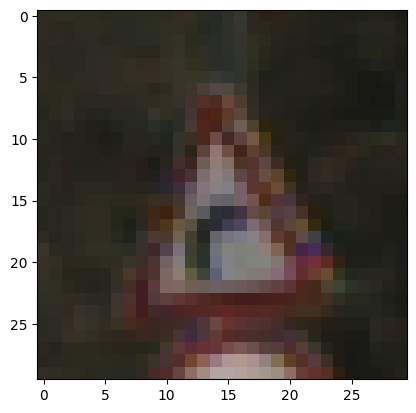

tensor([[-2.9516e+01, -2.7624e+01, -3.2045e+01, -2.0486e+01, -4.0616e+01,
         -2.3994e+01, -2.6361e+01, -2.8072e+01, -2.8373e+01, -2.4321e+01,
         -1.8116e+01, -1.4432e+01, -2.1591e+01, -3.1822e+01, -2.8267e+01,
         -3.3714e+01, -2.1121e+01, -2.6260e+01, -2.3749e+01, -1.8086e+01,
         -1.8120e-05, -2.7816e+01, -2.1432e+01, -1.3173e+01, -2.1679e+01,
         -1.2532e+01, -1.8581e+01, -1.9911e+01, -1.1359e+01, -1.6356e+01,
         -1.5128e+01, -2.3030e+01, -2.5708e+01, -3.6471e+01, -3.1043e+01,
         -2.8443e+01, -2.7378e+01, -3.6419e+01, -2.7560e+01, -3.5217e+01,
         -2.8609e+01, -2.2298e+01, -2.2145e+01]])
Predicted: tensor(20)
Actual number: tensor(20)


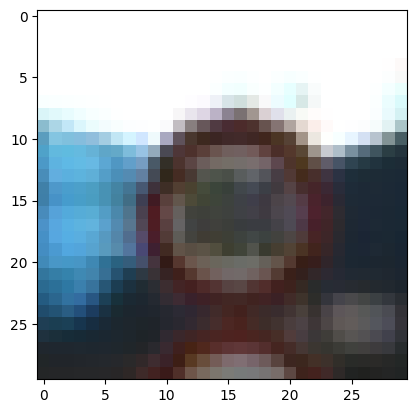

tensor([[-17.4598, -12.0976, -10.0865, -10.9250, -14.9497,  -0.1727, -13.9737,
          -1.9393,  -4.2171, -18.7888, -24.4998, -31.8945, -33.5029, -24.2411,
         -27.6384, -22.7889, -20.6304, -28.5450, -34.2997, -27.5056, -26.7731,
         -30.4261, -35.3346, -21.7114, -28.2359, -23.7838, -28.9478, -36.1633,
         -28.8987, -24.1190, -18.3153, -22.3466, -25.0704, -21.0865, -27.1861,
         -27.0888, -28.0456, -34.0011, -16.1731, -28.9593, -16.7810, -29.1679,
         -16.5129]])
Predicted: tensor(5)
Actual number: tensor(7)


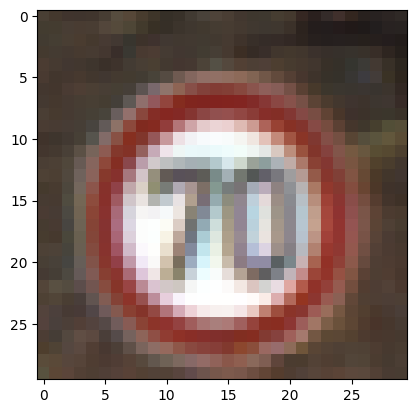

tensor([[-2.9811e+01, -1.9487e+01, -3.1832e+01, -5.3104e+01, -1.5497e-06,
         -4.4274e+01, -5.6196e+01, -3.2520e+01, -2.3089e+01, -3.1368e+01,
         -2.9873e+01, -5.5329e+01, -4.0010e+01, -3.1049e+01, -4.7027e+01,
         -2.5544e+01, -4.3800e+01, -3.0111e+01, -2.4136e+01, -1.3364e+01,
         -4.7245e+01, -4.0377e+01, -4.9616e+01, -4.5458e+01, -2.9034e+01,
         -3.6436e+01, -2.2851e+01, -4.5697e+01, -5.7389e+01, -5.3417e+01,
         -5.6028e+01, -3.9431e+01, -3.5077e+01, -3.8968e+01, -4.8413e+01,
         -4.6120e+01, -4.5410e+01, -3.6650e+01, -4.3665e+01, -4.5669e+01,
         -5.0858e+01, -4.1962e+01, -5.8702e+01]])
Predicted: tensor(4)
Actual number: tensor(4)


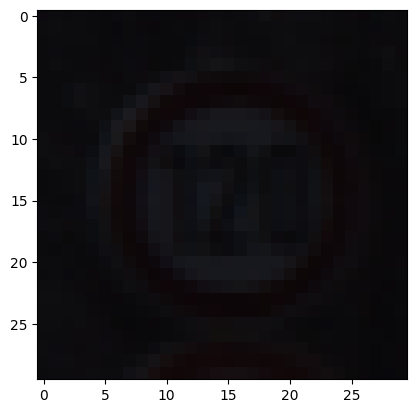

tensor([[-1.2842e+01, -1.3984e+01, -1.7776e+01, -1.9464e+01, -7.5974e+00,
         -1.1922e+01, -2.3717e+01, -7.7126e+00, -9.5953e-04, -1.6724e+01,
         -1.9224e+01, -3.3769e+01, -3.1149e+01, -2.3527e+01, -2.8476e+01,
         -2.2634e+01, -2.2767e+01, -2.0429e+01, -2.8170e+01, -1.9329e+01,
         -2.4422e+01, -3.0397e+01, -2.9682e+01, -2.3512e+01, -3.1256e+01,
         -2.4483e+01, -2.1602e+01, -3.4684e+01, -3.6265e+01, -2.8964e+01,
         -2.6977e+01, -2.4742e+01, -2.8127e+01, -2.4691e+01, -2.5427e+01,
         -2.9791e+01, -2.9134e+01, -2.8600e+01, -1.7541e+01, -2.7181e+01,
         -2.3087e+01, -2.8471e+01, -2.7933e+01]])
Predicted: tensor(8)
Actual number: tensor(8)


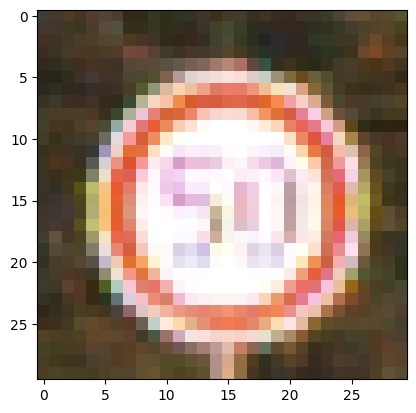

tensor([[-2.7007e+01, -1.0326e+01, -3.5881e-05, -2.9189e+01, -1.2701e+01,
         -1.9474e+01, -2.5428e+01, -2.5687e+01, -2.3240e+01, -3.3283e+01,
         -3.6886e+01, -4.7665e+01, -3.6566e+01, -2.9548e+01, -3.5635e+01,
         -2.3438e+01, -4.6634e+01, -4.8244e+01, -3.4616e+01, -3.2877e+01,
         -3.7928e+01, -3.6835e+01, -3.9454e+01, -3.7372e+01, -3.1858e+01,
         -3.2015e+01, -3.2743e+01, -4.7354e+01, -4.4219e+01, -3.3280e+01,
         -4.7479e+01, -2.1241e+01, -2.4665e+01, -2.8368e+01, -4.6956e+01,
         -3.7540e+01, -3.2058e+01, -3.8594e+01, -3.2855e+01, -3.3147e+01,
         -3.3458e+01, -3.8287e+01, -4.1269e+01]])
Predicted: tensor(2)
Actual number: tensor(2)


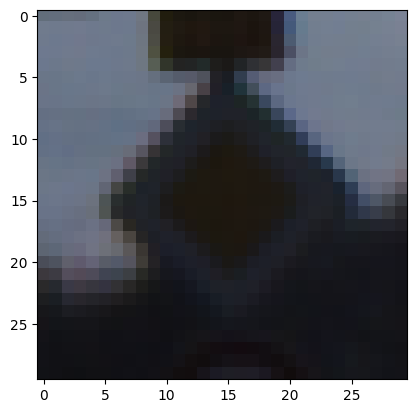

tensor([[-3.3895e+01, -2.5914e+01, -2.9875e+01, -2.0389e+01, -2.7529e+01,
         -2.5383e+01, -1.7627e+01, -2.9646e+01, -3.2534e+01, -2.9396e+01,
         -1.6924e+01, -1.6095e+01, -2.6941e-05, -1.3072e+01, -2.2004e+01,
         -2.9230e+01, -3.0133e+01, -1.9326e+01, -2.3931e+01, -2.8967e+01,
         -1.3745e+01, -3.5314e+01, -3.0744e+01, -3.3731e+01, -3.1077e+01,
         -1.5537e+01, -1.8626e+01, -3.0328e+01, -2.7169e+01, -3.5067e+01,
         -2.2084e+01, -3.8417e+01, -1.0662e+01, -2.4415e+01, -2.0711e+01,
         -2.5076e+01, -1.8524e+01, -2.5360e+01, -2.3018e+01, -2.6671e+01,
         -2.6762e+01, -1.7409e+01, -1.7089e+01]])
Predicted: tensor(12)
Actual number: tensor(12)


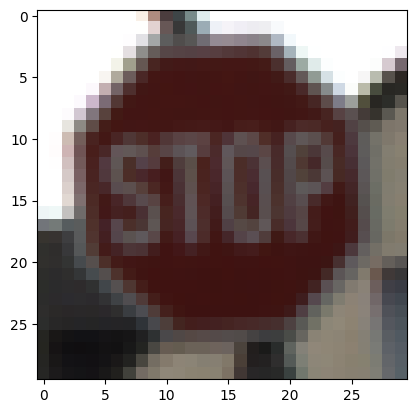

tensor([[-17.1895, -18.4763, -25.7779, -22.5473, -30.9951, -23.2458, -42.0828,
         -30.8085, -23.9894, -24.4565, -28.0136, -35.2652, -26.9445, -21.7176,
           0.0000, -20.2608, -30.3629, -18.9287, -27.7865, -40.2231, -24.7210,
         -43.0417, -20.6537, -36.2848, -35.3587, -21.5858, -25.8209, -34.3389,
         -24.3714, -18.4568, -32.1075, -33.9208, -24.3260, -38.0365, -37.6875,
         -33.0323, -31.6515, -48.6571, -35.9281, -39.1902, -39.5350, -39.5058,
         -43.4233]])
Predicted: tensor(14)
Actual number: tensor(14)


In [217]:
model.eval()
for i in range(17, 12630, 2000):
  with torch.no_grad():
    new_prediction = model(test_data[i][0].view(1,3,30,30))
  plt.imshow(test_data[i][0].permute(1, 2, 0))
  plt.show()
  print(new_prediction)
  print("Predicted:", new_prediction.argmax())
  print("Actual number:", y_test[i])